In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import torch

# Create synthetic nonlinear data since NonLinear_data.npy doesn't exist
from sklearn.datasets import make_classification

X, labels = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_classes=3,
    n_clusters_per_class=1,
    random_state=42
)

X = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)
X, labels

(tensor([[-0.8556, -1.3365],
         [-0.9221, -1.0629],
         [-0.2027, -0.8219],
         ...,
         [ 1.5530,  0.2719],
         [ 0.3596, -0.9259],
         [ 0.2630,  1.5602]]),
 tensor([2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 0, 2, 1,
         2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1,
         0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 1, 2, 2, 0,
         2, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 0,
         1, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1,
         1, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2,
         1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2,
         1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 2, 0, 0,
         2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2,
         0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0,


In [5]:
X_np = X.detach().cpu().numpy()

column_names = [f"Feature_{i}" for i in range(X_np.shape[1])]

df = pd.DataFrame(X_np, columns=column_names)

df['Target'] = labels.detach().cpu().numpy()

df.head()

,Feature_0,Feature_1,Target
0,-0.855597,-1.336502,2
1,-0.922102,-1.062900,2
2,-0.202714,-0.821910,2
3,0.969746,1.537000,1
4,-1.008583,-0.796954,2


In [6]:
x = df.drop(['Target'], axis=1)
y = df['Target']

print('So dac trung:', x.shape[1])
print('So nhan:', len(y.unique()))
print('Phan phoi nhan:', np.bincount(y))
x.shape, y.shape

So dac trung: 2
So nhan: 3
Phan phoi nhan: [332 333 335]


((1000, 2), (1000,))

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train set: {x_train.shape[0]} samples")
print(f"  Class distribution: {np.bincount(y_train)}")
print(f"Val set: {x_val.shape[0]} samples")
print(f"  Class distribution: {np.bincount(y_val)}")
print(f"Test set: {x_test.shape[0]} samples")
print(f"  Class distribution: {np.bincount(y_test)}")

Train set: 700 samples
  Class distribution: [232 233 235]
Val set: 150 samples
  Class distribution: [50 50 50]
Test set: 150 samples
  Class distribution: [50 50 50]


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

print("Features normalized using StandardScaler")
print(f"Train mean: {x_train_scaled.mean(axis=0)[:3]}... (first 3 features)")
print(f"Train std: {x_train_scaled.std(axis=0)[:3]}... (first 3 features)")

x_train, x_val, x_test = x_train_scaled, x_val_scaled, x_test_scaled

Features normalized using StandardScaler
Train mean: [9.0258458e-09 1.5837806e-08]... (first 3 features)
Train std: [0.9999995 1.       ]... (first 3 features)


In [9]:
class Linear:
    def __init__(self, input_dim: int, output_dim: int):
        self.weights = np.random.uniform(-1, 1, (input_dim, output_dim))
        self.biases = np.zeros((output_dim,))

        self.input = None

        self.num_params = output_dim * input_dim + output_dim
    
    def forward(self, x):
        self.input = x
        return x @ self.weights + self.biases
    
    def backward(self, grad_output, lr):
        grad_input = grad_output @ self.weights.T

        self.lr = lr
        m = self.input.shape[0]

        d_weights = (self.input.T @ grad_output) / m
        d_biases = np.mean(grad_output, axis=0)

        self.weights -= lr * d_weights
        self.biases -= lr * d_biases

        return grad_input
    
linear = Linear(2, 100)
print(x_train.shape)
output = linear.forward(x_train)
print(f"Output shape: {output.shape}")
output

(700, 2)
Output shape: (700, 100)


array([[-0.83346102,  0.76890649,  0.97184944, ..., -1.62737992,
        -0.28112454,  1.05088935],
       [-0.28729437,  0.31496415, -0.37250229, ..., -0.25990366,
         0.5390563 ,  0.33913334],
       [-0.70938085,  0.66670393,  0.65331473, ..., -1.3111288 ,
        -0.08299955,  0.88876144],
       ...,
       [-0.7447876 ,  0.75400271, -0.07968731, ..., -1.05078775,
         0.60105306,  0.90811474],
       [-1.25885309,  1.2170133 ,  0.6790105 , ..., -2.12230508,
         0.28448871,  1.56148892],
       [-0.7822455 ,  0.74419187,  0.59277339, ..., -1.39148612,
         0.02321509,  0.97588204]], shape=(700, 100))

In [10]:
class ReLU():
    def __init__(self):
        self.input = None
    
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0).astype(float)
        return grad_input
    
relu = ReLU()
output = relu.forward(output)
print(f"Output shape: {output.shape}")
print(output)

Output shape: (700, 100)
[[0.         0.76890649 0.97184944 ... 0.         0.         1.05088935]
 [0.         0.31496415 0.         ... 0.         0.5390563  0.33913334]
 [0.         0.66670393 0.65331473 ... 0.         0.         0.88876144]
 ...
 [0.         0.75400271 0.         ... 0.         0.60105306 0.90811474]
 [0.         1.2170133  0.6790105  ... 0.         0.28448871 1.56148892]
 [0.         0.74419187 0.59277339 ... 0.         0.02321509 0.97588204]]


In [12]:
class Softmax():
    def forward(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def backward(self, y, y_pred):
        m = y.shape[0]
        d_scores = y_pred.copy()
        d_scores[np.arange(m), y] -= 1
        d_scores /= m
        return d_scores

softmax = Softmax()
output = softmax.forward(output)
print(f"Output shape: {output.shape}")

Output shape: (700, 100)


In [13]:
def cross_entropy(y, y_pred):
    n = y.shape[0]
    n_classes = y_pred.shape[1]
    y_onehot = np.zeros((n, n_classes))
    y_onehot[np.arange(n), y] = 1
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = -np.mean(np.sum(y_onehot * np.log(y_pred), axis=1))
    return loss

In [14]:
class ArtificialNeuralNetwork:
    def __init__(self, input_dim: int, output_dim: int):
        self.linear1 = Linear(input_dim, 100)
        print(f"Linear1 parameters: {self.linear1.num_params}")
        self.relu1 = ReLU()

        self.linear2 = Linear(100, 200)
        print(f"Linear2 parameters: {self.linear2.num_params}")
        self.relu2 = ReLU()

        self.linear3 = Linear(200, 100)
        print(f"Linear3 parameters: {self.linear3.num_params}")
        self.relu3 = ReLU()

        self.linear4 = Linear(100, output_dim)
        print(f"Linear4 parameters: {self.linear4.num_params}")
        self.softmax = Softmax()
        print(f"total parameters: {self.linear1.num_params + self.linear2.num_params + self.linear3.num_params + self.linear4.num_params}")
    
    def forward(self, x):
        out = self.linear1.forward(x)
        out = self.relu1.forward(out)
        out = self.linear2.forward(out)
        out = self.relu2.forward(out)
        out = self.linear3.forward(out)
        out = self.relu3.forward(out)
        out = self.linear4.forward(out)
        out = self.softmax.forward(out)
        return out
    
    def backward(self, y, y_pred, lr):
        grad_softmax = softmax.backward(y, y_pred)
        grad = self.linear4.backward(grad_softmax, lr)
        grad = self.relu3.backward(grad)
        grad = self.linear3.backward(grad, lr)
        grad = self.relu2.backward(grad)
        grad = self.linear2.backward(grad, lr)
        grad = self.relu1.backward(grad)
        grad = self.linear1.backward(grad, lr)
        return grad
    
    def save(self, filepath):
        np.savez(
            filepath,
            linear1_weights=self.linear1.weights,
            linear1_biases=self.linear1.biases,
            linear2_weights=self.linear2.weights,
            linear2_biases=self.linear2.biases,
            linear3_weights=self.linear3.weights,
            linear3_biases=self.linear3.biases,
            linear4_weights=self.linear4.weights,
            linear4_biases=self.linear4.biases,
        )

    def load(self, filepath):
        data = np.load(filepath)
        self.linear1.weights = data['linear1_weights']
        self.linear1.biases = data['linear1_biases']
        self.linear2.weights = data['linear2_weights']
        self.linear2.biases = data['linear2_biases']
        self.linear3.weights = data['linear3_weights']
        self.linear3.biases = data['linear3_biases']
        self.linear4.weights = data['linear4_weights']
        self.linear4.biases = data['linear4_biases']
        print(f"Model loaded from {filepath}")
    
    def fit(self, x_train, y_train, x_val, y_val, epochs: int, lr: float):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            y_pred = self.forward(x_train)
            self.backward(y_train, y_pred, lr)

            train_loss = cross_entropy(y_train, y_pred)
            train_losses.append(train_loss)
            train_acc = np.mean(np.argmax(y_pred, axis=1) == y_train)
            self.save("last-nonlinear-model.npz")

            y_pred_val = self.forward(x_val)
            val_loss = cross_entropy(y_val, y_pred_val)
            if val_losses and val_loss < val_losses[-1]:
                self.save("best-nonlinear-model.npz")
            val_losses.append(val_loss)
            val_acc = np.mean(np.argmax(y_pred_val, axis=1) == y_val)

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        return train_losses, val_losses

    def predict(self, x):
        y_pred = self.forward(x)
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

nn = ArtificialNeuralNetwork(2, 3)
output = nn.forward(x_train)
print(f"Output shape: {output.shape}")
output

Linear1 parameters: 300
Linear2 parameters: 20200
Linear3 parameters: 20100
Linear4 parameters: 303
total parameters: 40903
Output shape: (700, 3)


array([[9.99999991e-001, 9.04556447e-009, 6.29004551e-147],
       [9.50407921e-011, 1.00000000e+000, 9.36056032e-034],
       [9.99999999e-001, 7.43293267e-010, 2.42279758e-112],
       ...,
       [1.77206047e-002, 9.82279395e-001, 1.43584942e-073],
       [1.00000000e+000, 1.33662742e-018, 1.05066196e-160],
       [1.00000000e+000, 2.05233611e-012, 4.61091510e-114]],
      shape=(700, 3))

In [ ]:
train_losses, val_losses = nn.fit(x_train, y_train, x_val, y_val, 1000, 0.1)

Epoch 1/1000, Train Loss: 20.9879, Train Acc: 0.3333, Val Loss: 18.1464, Val Acc: 0.3333
Epoch 10/1000, Train Loss: 9.4699, Train Acc: 0.4333, Val Loss: 8.3610, Val Acc: 0.4222
Epoch 20/1000, Train Loss: 5.4718, Train Acc: 0.4667, Val Loss: 4.8309, Val Acc: 0.4667
Epoch 30/1000, Train Loss: 2.8478, Train Acc: 0.5571, Val Loss: 2.5543, Val Acc: 0.5556
Epoch 40/1000, Train Loss: 1.6182, Train Acc: 0.6571, Val Loss: 1.5386, Val Acc: 0.6444
Epoch 50/1000, Train Loss: 1.0505, Train Acc: 0.7429, Val Loss: 0.9983, Val Acc: 0.6889
Epoch 60/1000, Train Loss: 0.7107, Train Acc: 0.8143, Val Loss: 0.6881, Val Acc: 0.7556
Epoch 70/1000, Train Loss: 0.4883, Train Acc: 0.8714, Val Loss: 0.5226, Val Acc: 0.8222
Epoch 80/1000, Train Loss: 0.3333, Train Acc: 0.9000, Val Loss: 0.4237, Val Acc: 0.8444
Epoch 90/1000, Train Loss: 0.2320, Train Acc: 0.9238, Val Loss: 0.3569, Val Acc: 0.8444
Epoch 100/1000, Train Loss: 0.1863, Train Acc: 0.9429, Val Loss: 0.3150, Val Acc: 0.8889
Epoch 110/1000, Train Loss: 0.

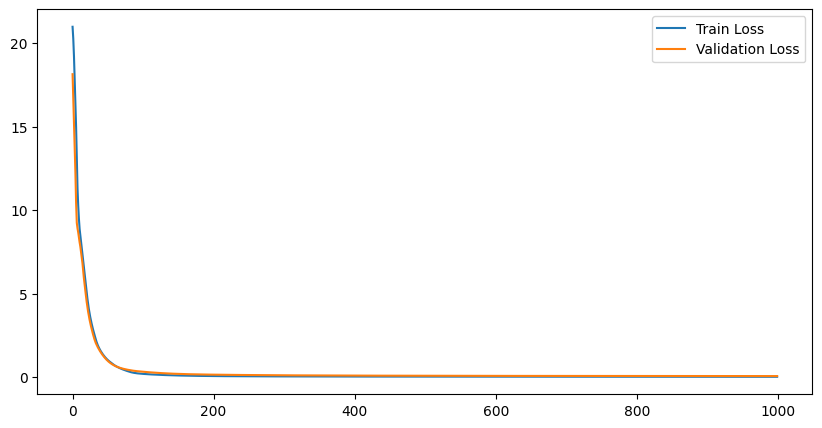

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
trained_model = ArtificialNeuralNetwork(2, 3)
trained_model.load("best-nonlinear-model.npz")

y_pred_test = trained_model.predict(x_test)
test_acc = np.mean(y_pred_test == y_test)

from sklearn.metrics import classification_report, confusion_matrix

print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Linear1 parameters: 300
Linear2 parameters: 20200
Linear3 parameters: 20100
Linear4 parameters: 303
total parameters: 40903
Model loaded from best-nonlinear-model.npz
Test Accuracy: 0.9333

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       1.00      0.93      0.97        15
           2       0.93      0.93      0.93        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


Confusion Matrix:
[[14  0  1]
 [ 1 14  0]
 [ 1  0 14]]
